In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/outta/clothes_segmentation

Mounted at /content/drive
/content/drive/MyDrive/outta/clothes_segmentation


In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.functional import F
from tqdm.auto import tqdm
import seaborn as sns

from codes.load_testset import load_testset
from codes.show_result import show_segment, show_test_output
from codes.test_F1 import evaluate_F1
from codes.test_mIoU import evaluate_mIoU
from models.u2_net import U2NET_lite
from loss.scloss import SCLoss

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = U2NET_lite(7).to(device=device)

In [7]:
train_loader, valid_loader = load_testset('../outta_3_project/dataset/G2_train.h5', 8000, 2000)
# 개인 데이터셋 경로로 지정할 것

torch.Size([8000, 3, 128, 128]) torch.Size([8000, 128, 128])


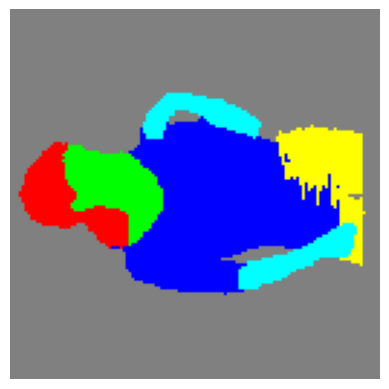

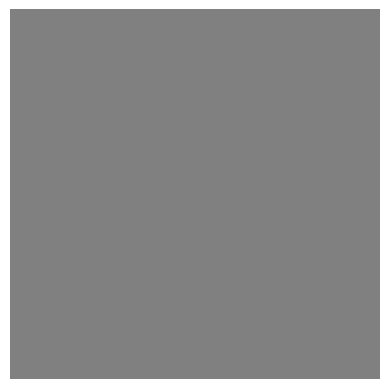

In [8]:
test_input = None
test_label = None
for i, j in valid_loader:
    test_input = i[2]
    test_label = j[2]

show_test_output(model, test_input, test_label, device)

In [9]:
criterion = CrossEntropyLoss()
sc_loss = SCLoss()
optimizer = Adam(model.parameters(), lr=1e-8)

In [10]:
train = []
valid = []
f1 = []
miou = []

In [20]:
def train_valid(model, criterion, sc_loss, L,optimizer, trainloader, validloader, num_epochs=1):
    count = 0
    train_losses = []
    valid_losses = []
    f1_scores = []
    miou_scores = []

    for epoch in tqdm(range(num_epochs)):
        train_losses.append(epoch_loop(model, criterion, sc_loss, L,optimizer, trainloader))
        valid_losses.append(epoch_loop(model, criterion, sc_loss, L,optimizer, validloader, valid = True))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}')

        f1_scores.append(evaluate_F1(model, valid_loader, 7, device))
        miou_scores.append(evaluate_mIoU(model, valid_loader, 7, device))

        print(f'Epoch {epoch+1}/{num_epochs}, F1: {f1_scores[-1]}, mioU: {miou_scores[-1]}')

        show_test_output(model, test_input, test_label, device)


        if train_losses[-1] > valid_losses[-1]:
            count += 1
            if count > 3:
                print('early stop')


        if min(valid_losses) == valid_losses[-1]:
            torch.save(model.state_dict(), f'../../../../model_{epoch}.pth')


    return train_losses, valid_losses, f1_scores, miou_scores


In [17]:
def epoch_loop(model, criterion, sc_loss, L, optimizer, dataloader, valid=False):
    epoch_loss = 0

    if valid:
        model.eval()
    else:
        model.train()

    for inputs, targets in tqdm(dataloader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.long()

        # Forward pass
        outputs = model(inputs)

        # Main Loss 계산 (CrossEntropyLoss)
        ce_loss = criterion(outputs, targets)

        # SCLoss 계산
        outputs_probs = F.softmax(outputs, dim=1)
        targets_onehot = F.one_hot(targets, num_classes=outputs.shape[1]).permute(0, 3, 1, 2).float()
        sc_loss_value = sc_loss(outputs_probs, targets_onehot)

        loss = ce_loss + L * sc_loss_value

        if not valid:
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()

        del inputs, targets, outputs, ce_loss, outputs_probs, targets_onehot, sc_loss_value, loss
        torch.cuda.empty_cache()

    return epoch_loss/len(dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.100981201171875, Valid Loss: 0.09148318994612921
Epoch 1/10, F1: 0.8860319502769954, mioU: 0.8015587415013995


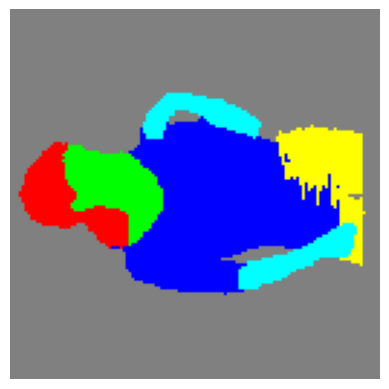

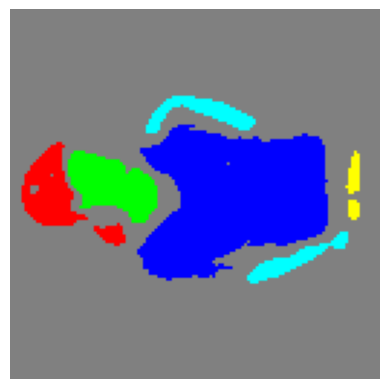

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.084454485014081, Valid Loss: 0.0846153377067475
Epoch 2/10, F1: 0.8907223154628088, mioU: 0.8093735178311666


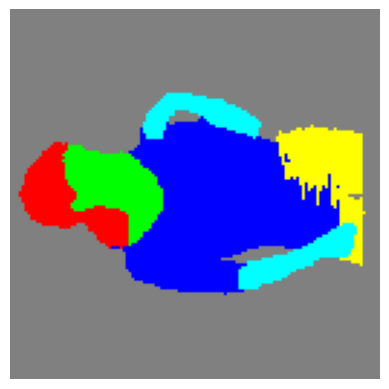

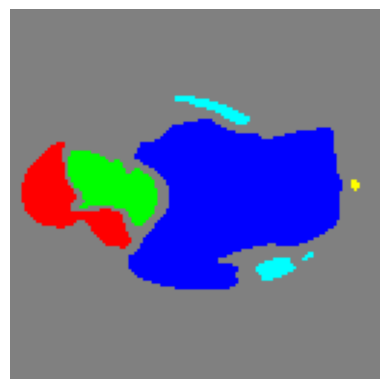

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.07615714794397355, Valid Loss: 0.0804553029556123
Epoch 3/10, F1: 0.8986285092338683, mioU: 0.822235001458062


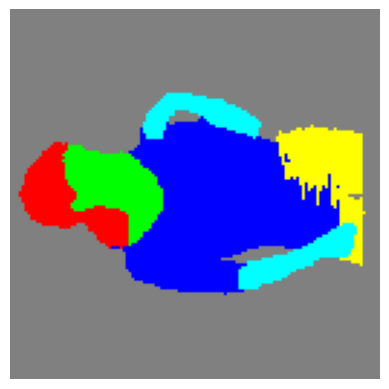

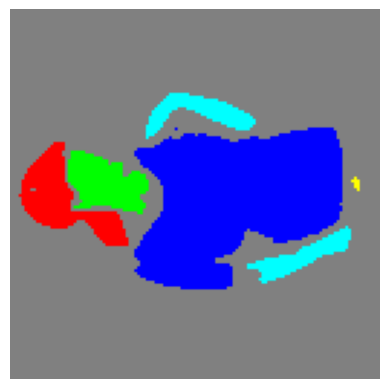

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.07116098724305629, Valid Loss: 0.07573196705844668
Epoch 4/10, F1: 0.9050596403697181, mioU: 0.831029907105461


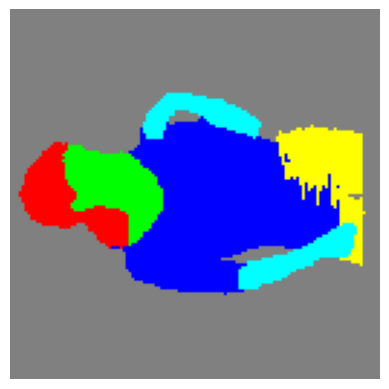

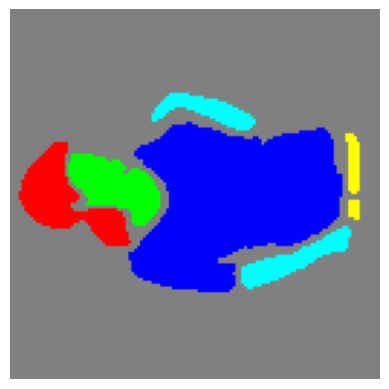

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)
t, v, f, m = train_valid(model, criterion, sc_loss, 0.5, optimizer, train_loader, valid_loader, num_epochs=10)
train += t
valid += v
f1 += f
miou + m

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-6)
t, v = train_valid(model, criterion, sc_loss, 0.5, optimizer, train_loader, valid_loader, num_epochs=5)
train += t
valid += v
f1 += f
miou + m

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-8)
t, v = train_valid(model, criterion, sc_loss, 0.5, optimizer, train_loader, valid_loader, num_epochs=5)
train += t
valid += v
f1 += f
miou + m

In [ ]:
sns.lineplot((train, valid))

In [ ]:
1e-4, 1e-6